# Load package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

data_dir = './Flowers'
subset = os.listdir(data_dir)

# Profiling data

In [2]:
data_info = pd.DataFrame()
for i in subset:

    count = len(os.listdir(os.path.join(data_dir, i)))
    data_info.at[0,i] =  count
    print(i , ' : ', count)

Babi  :  931
Calimerio  :  353
Chrysanthemum  :  696
Hydrangeas  :  518
Lisianthus  :  969
Pingpong  :  360
Rosy  :  171
Tana  :  623


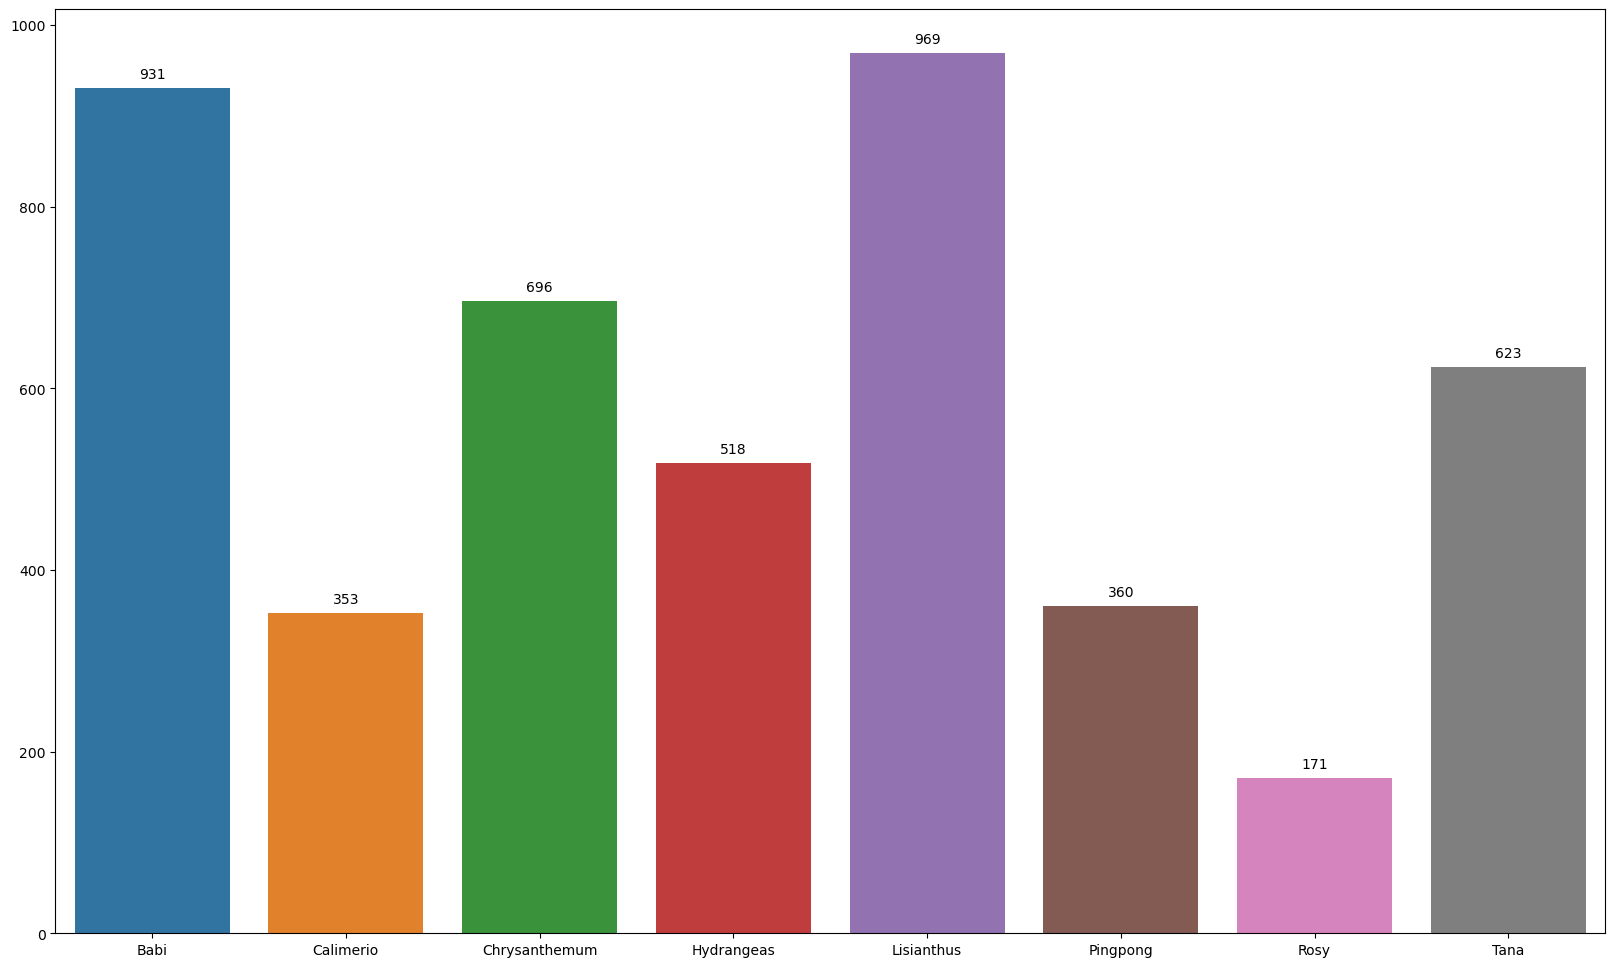

In [15]:
plt.figure(figsize=(20,12))
ax = sns.barplot(data=data_info)

# add counts above the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()

# Train Test split

In [4]:
from sklearn.model_selection import train_test_split

# 0.7 train -> 0.2 test -> 0.1 val

classes = os.listdir(data_dir)
classes.sort()
class_to_idx = {classes[i]: i for i in range(len(classes))}

train_data = []
test_data = []

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    images = os.listdir(class_dir)
    images = [os.path.join(class_dir, img) for img in images]
    targets = [class_to_idx[class_name]] * len(images)

    train_images, test_images, train_targets, test_targets = train_test_split(images, targets, test_size=0.3, random_state=42)

    train_data += list(zip(train_images, train_targets))
    test_data += list(zip(test_images, test_targets))

print(f'Train samples: {len(train_data)}')
print(f'Test samples: {len(test_data)}')


Train samples: 3232
Test samples: 1389


In [5]:
import os
import shutil

X_train, y_train  = [],[]
X_test, y_test  = [],[]

for i in range(len(train_data)):
    X_train.append(train_data[i][0])
    y_train.append(train_data[i][1])

for i in range(len(test_data)):
    X_test.append(test_data[i][0])
    y_test.append(test_data[i][1])

# create new directory for symbolic links
train_dir = 'Train'
os.makedirs(train_dir, exist_ok=True)

# create symbolic links for each image in X_train
for img_path in X_train:
    class_name = os.path.basename(os.path.dirname(img_path))
    class_dir = os.path.join(train_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    link_path = os.path.join(class_dir, f'{os.path.basename(img_path)}')
    abs_path = os.path.abspath(img_path)  # convert relative path to absolute path
    os.symlink(abs_path, link_path)

test_dir = 'Test'
os.makedirs(test_dir, exist_ok=True)

# create symbolic links for each image in X_test
for img_path in X_test:
    class_name = os.path.basename(os.path.dirname(img_path))
    class_dir = os.path.join(test_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    link_path = os.path.join(class_dir, f'{os.path.basename(img_path)}')
    abs_path = os.path.abspath(img_path)  # convert relative path to absolute path
    os.symlink(abs_path, link_path)


Train: Babi : 651
Train: Calimerio : 247
Train: Chrysanthemum : 487
Train: Hydrangeas : 362
Train: Lisianthus : 678
Train: Pingpong : 252
Train: Rosy : 119
Train: Tana : 436
Test: Babi : 280
Test: Calimerio : 106
Test: Chrysanthemum : 209
Test: Hydrangeas : 156
Test: Lisianthus : 291
Test: Pingpong : 108
Test: Rosy : 52
Test: Tana : 187


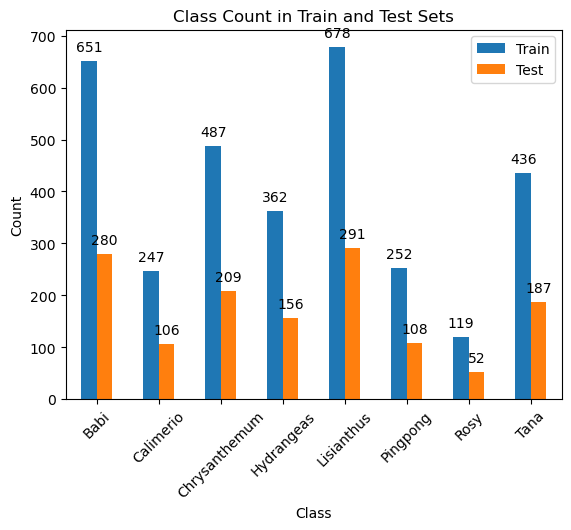

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

data_dir_train = './Train/'
data_dir_test = './Test/'

train_subset = os.listdir(data_dir_train)
test_subset = os.listdir(data_dir_test)

train_counts = []
test_counts = []

for i in train_subset:
    count = len(os.listdir(os.path.join(data_dir_train, i)))
    train_counts.append(count)
    print('Train:', i, ':', count)

for i in test_subset:
    count = len(os.listdir(os.path.join(data_dir_test, i)))
    test_counts.append(count)
    print('Test:', i, ':', count)

class_names = train_subset  # Assuming train and test subsets have the same class names

# Create a DataFrame for visualization
data = pd.DataFrame({'Train': train_counts, 'Test': test_counts}, index=class_names)

# Plot the double bar chart
ax = data.plot(kind='bar')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Count in Train and Test Sets')
plt.xticks(rotation=45)

# Add counts above the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

plt.show()


# Modelings

## Load Packge

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from collections import defaultdict
from PIL import Image
import numpy as np
import torch.nn.functional as F
import os
import torchvision.models as models

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    self.expansion * out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * out_channels),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride

        if stride != 1 or in_channels != out_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )
        else:
            self.downsample = nn.Identity()

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        identity = self.downsample(identity)

        out += identity
        out = self.relu(out)

        return out

class FlowerClassifier(nn.Module):
    def __init__(self,train_dir, test_dir):

        super(FlowerClassifier, self).__init__() # Resnet18
        self.history = defaultdict(list)
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.in_channels = 64
        block = BasicBlock
        layers = [2, 2, 2, 2]
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, 8)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def train_model(self, batch_size=64, epochs=10, learning_rate=0.0001):

        # AUGMENT 
        transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        # LOADING
        self.train_dataset = datasets.ImageFolder(self.train_dir, transform=transform)
        train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)

        test_dataset = datasets.ImageFolder(self.test_dir, transform=transform)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


        # CUSTOM LOSS <> --------------------------------------
        criterion_2 = nn.CrossEntropyLoss()
        num_classes = len(self.train_dataset.classes) 
        criterion = nn.MultiLabelSoftMarginLoss()
        # CUSTOM LOSS <> --------------------------------------

        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        optimizer2 = optim.SGD(self.parameters(), lr=learning_rate, momentum=1)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        for epoch in tqdm(range(epochs)):
            self.train()
            train_loss = 0
            train_correct = 0
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                optimizer2.zero_grad()

                labels_onehot = F.one_hot(labels, num_classes).float()
                labels_onehot = labels_onehot.to(device)

                outputs = self(images)

                loss_2 = criterion_2(outputs, labels)
                loss = criterion(outputs, labels_onehot)

                total_loss = (loss + loss_2)/2

                total_loss.backward()
                optimizer.step()
                optimizer2.step()
                train_loss += total_loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_correct += (predicted == labels).sum().item()
            train_accuracy = 100 * train_correct / len(self.train_dataset)

            self.eval()
            test_loss = 0
            test_correct = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)

                    labels_onehot = F.one_hot(labels, num_classes).float()
                    labels_onehot = labels_onehot.to(device)

                    outputs = self(images)

                    loss_2 = criterion_2(outputs, labels)
                    loss = criterion(outputs, labels_onehot)

                    total_loss = (loss + loss_2)/2

                    test_loss += total_loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    test_correct += (predicted == labels).sum().item()
                test_accuracy = 100 * test_correct / len(test_dataset)

            print(f'\n Epoch {epoch+1} | '
                f'Training loss: {train_loss:.4f} | '
                f'Training accuracy: {train_accuracy:.2f}% | '
                f'Test loss: {test_loss:.4f} | '
                f'Test accuracy: {test_accuracy:.2f}%')
            
            self.history['train_loss'].append(f'{train_loss:.4f}')
            self.history['test_loss'].append(f'{test_loss:.2f}')
            self.history['train_acc'].append(f'{train_accuracy:.4f}')
            self.history['test_loss'].append(f'{test_accuracy:.2f}')

            scheduler.step()
        self.cpu()

    def predict(self, image_path):
        transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
            
        new_image = Image.open(image_path).convert('RGB')
        new_image_tensor = transform(new_image).unsqueeze(0)
        new_image_tensor = new_image_tensor.to(device)
        self.cpu()
        # make a prediction
        self.eval()
        with torch.no_grad():
            outputs = self(new_image_tensor)
            _, predicted = torch.max(outputs.data, 1)
            class_index = predicted.item()
        # get the class label
        class_label = self.train_dataset.classes[class_index]
        print(f'The image belongs to the {class_label} class.')

## Training

In [9]:
## thinking before training , it will take a lot of time
train_dir='./Train/'
test_dir='./Test/'

model = FlowerClassifier(train_dir, test_dir)
model.train_model(epochs=10,learning_rate= 0.0001)
torch.save(model.state_dict(), 'model_5.pth')


 10%|████████▏                                                                         | 1/10 [05:13<46:57, 313.09s/it]


 Epoch 1 | Training loss: 50.7768 | Training accuracy: 42.23% | Test loss: 19.2592 | Test accuracy: 50.76%


 20%|████████████████▍                                                                 | 2/10 [10:36<42:32, 319.02s/it]


 Epoch 2 | Training loss: 39.4949 | Training accuracy: 53.74% | Test loss: 22.5939 | Test accuracy: 45.93%


 30%|████████████████████████▌                                                         | 3/10 [16:04<37:43, 323.33s/it]


 Epoch 3 | Training loss: 35.6483 | Training accuracy: 57.61% | Test loss: 16.3134 | Test accuracy: 57.09%


 40%|████████████████████████████████▊                                                 | 4/10 [21:22<32:05, 320.98s/it]


 Epoch 4 | Training loss: 33.5470 | Training accuracy: 61.42% | Test loss: 17.6209 | Test accuracy: 55.65%


 50%|█████████████████████████████████████████                                         | 5/10 [26:22<26:08, 313.65s/it]


 Epoch 5 | Training loss: 30.7293 | Training accuracy: 65.22% | Test loss: 14.5689 | Test accuracy: 61.99%


 60%|█████████████████████████████████████████████████▏                                | 6/10 [31:52<21:16, 319.07s/it]


 Epoch 6 | Training loss: 26.9539 | Training accuracy: 70.30% | Test loss: 14.0152 | Test accuracy: 63.14%


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [37:08<15:54, 318.01s/it]


 Epoch 7 | Training loss: 24.6984 | Training accuracy: 72.34% | Test loss: 12.1687 | Test accuracy: 68.97%


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [42:12<10:27, 313.69s/it]


 Epoch 8 | Training loss: 23.1026 | Training accuracy: 74.50% | Test loss: 11.7785 | Test accuracy: 70.05%


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [47:02<05:06, 306.38s/it]


 Epoch 9 | Training loss: 21.3322 | Training accuracy: 76.05% | Test loss: 12.1267 | Test accuracy: 69.11%


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [51:48<00:00, 310.82s/it]


 Epoch 10 | Training loss: 20.3827 | Training accuracy: 76.73% | Test loss: 12.9319 | Test accuracy: 67.10%


## Evaluate

In [40]:
model = FlowerClassifier(train_dir,test_dir)

model.load_state_dict(torch.load('model_5.pth'))

<All keys matched successfully>

In [41]:
import torch.utils.data as data
from sklearn.metrics import confusion_matrix

model.eval()
transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
eval_dataset = datasets.ImageFolder(root='./Test/', transform=transform)
eval_loader = data.DataLoader(eval_dataset, batch_size=16, shuffle=True)

# Initialize the prediction and label lists
predlist = torch.zeros(0,dtype=torch.long, device='cpu')
lbllist = torch.zeros(0,dtype=torch.long, device='cpu')

# Evaluate the model accuracy on the dataset
correct = 0
total = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for images, labels in eval_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

# Overall accuracy
overall_accuracy=100 * correct / total
print('Accuracy of the network on the {:d} test images: {:.2f}%'.format(8, overall_accuracy))
# Confusion matrix
conf_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
print('Confusion Matrix')
print('-'*16)
print(conf_mat,'\n')

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print('Per class accuracy')
print('-'*18)
for label,accuracy in zip(eval_dataset.classes, class_accuracy):
    print('Accuracy of class %8s : %0.2f %%'%(label, accuracy))


Accuracy of the network on the 8 test images: 67.60%
Confusion Matrix
----------------
[[249   1   4   7   7   4   2   6]
 [  3  64   4   0  17   3  13   2]
 [ 15   4  82   3   2   1   6  96]
 [ 23   2   5  83  26   8   6   3]
 [  4  28   2  22 218   8   5   4]
 [  3  10   1  12  33  40   8   1]
 [  1   3   0   0   4   0  44   0]
 [  9   5  10   2   2   0   0 159]] 

Per class accuracy
------------------
Accuracy of class     Babi : 88.93 %
Accuracy of class Calimerio : 60.38 %
Accuracy of class Chrysanthemum : 39.23 %
Accuracy of class Hydrangeas : 53.21 %
Accuracy of class Lisianthus : 74.91 %
Accuracy of class Pingpong : 37.04 %
Accuracy of class     Rosy : 84.62 %
Accuracy of class     Tana : 85.03 %


In [18]:
## it is the best as i can

## Predict testing

In [2]:
model.eval()
path = 'Test/Babi/babi_40.jpg'
image = Image.open(path)
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)

# Make predictions
with torch.no_grad():
    outputs = model(input_batch)
    _, predicted = torch.max(outputs.data, 1)
    class_index = predicted.item()
# get the class label
class_label = classes[class_index]
print(f'The image belongs to the {class_label} class.')


# Or u can you it 
# model.predict(path)

NameError: name 'model' is not defined

# Recommendation

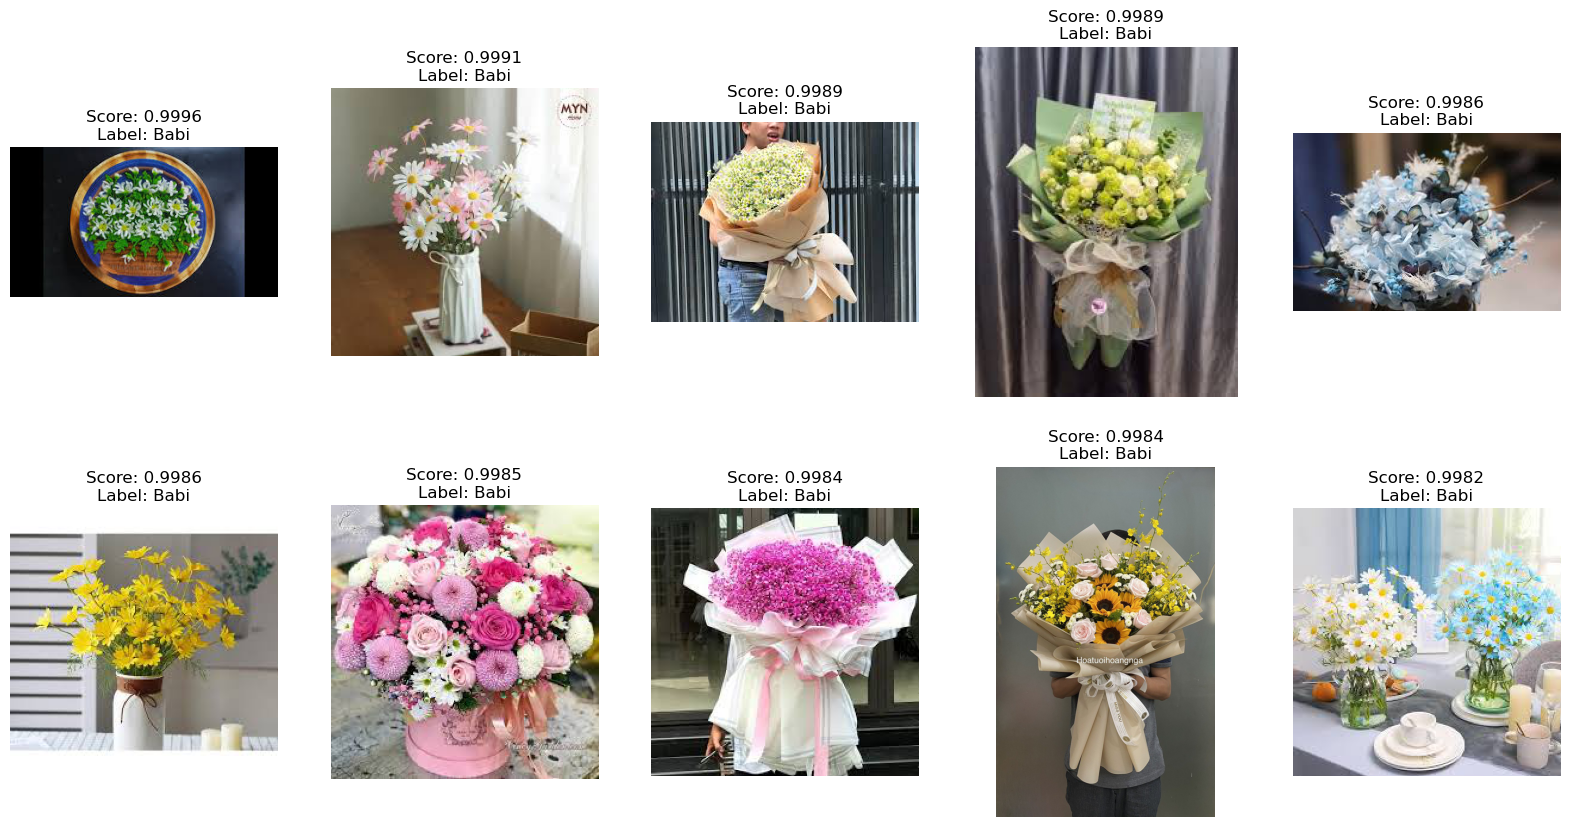

In [54]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
from PIL import Image

# load the test image
test_image = Image.open('Test/Babi/babi_40.jpg')

# apply the same transformations used during training and evaluation
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_image = transform(test_image).unsqueeze(0)

# load the trained model

model = FlowerClassifier(train_dir, test_dir)
model.load_state_dict(torch.load('model_5.pth'))

# generate predictions for all images in the training set
train_dataset = datasets.ImageFolder(root='./Train/', transform=transform)
train_loader = data.DataLoader(train_dataset, batch_size=16, shuffle=True)

train_features = []
train_labels = []

model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        features = model(images)
        train_features.append(features)
        train_labels.append(labels)

train_features = torch.cat(train_features, dim=0)
train_labels = torch.cat(train_labels, dim=0)

# compute similarity scores
test_features = model(test_image)
similarity_scores = torch.nn.functional.cosine_similarity(train_features, test_features)

# sort the similarity scores and select the top-k images
k = 10
top_k_scores, top_k_indices = torch.topk(similarity_scores, k, dim=0)

# display the top-k similar images along with their class labels
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten()
for i in range(k):
    index = top_k_indices[i]
    score = top_k_scores[i]
    label = train_dataset.classes[train_labels[index]]
    image_path = train_dataset.imgs[index][0]
    similar_image = Image.open(image_path)
    axs[i].imshow(similar_image)
    axs[i].set_title(f"Score: {score:.4f}\nLabel: {label}")
    axs[i].axis('off')
plt.show()

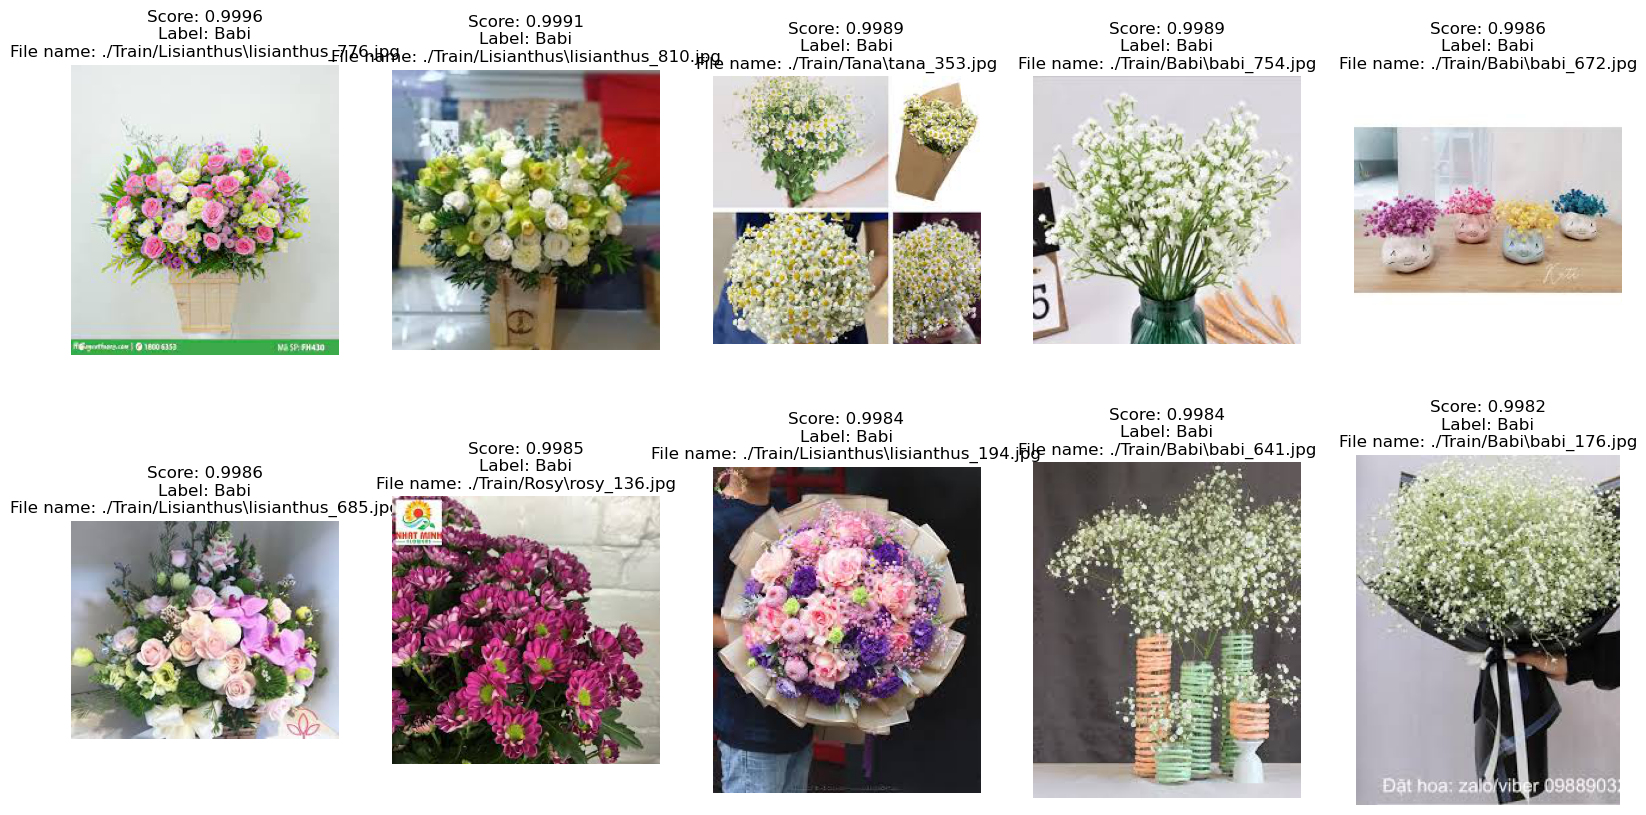

In [62]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
from PIL import Image

# load the test image
test_image = Image.open('Test/Babi/babi_40.jpg')

# apply the same transformations used during training and evaluation
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_image = transform(test_image).unsqueeze(0)

# load the trained model

model = FlowerClassifier(train_dir, test_dir)
model.load_state_dict(torch.load('model_5.pth'))

# generate predictions for all images in the training set
train_dataset = datasets.ImageFolder(root='./Train/', transform=transform)
train_loader = data.DataLoader(train_dataset, batch_size=16, shuffle=True)

train_features = []
train_labels = []

model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        features = model(images)
        train_features.append(features)
        train_labels.append(labels)

train_features = torch.cat(train_features, dim=0)
train_labels = torch.cat(train_labels, dim=0)

# compute similarity scores
test_features = model(test_image)
similarity_scores = torch.nn.functional.cosine_similarity(train_features, test_features)

# sort the similarity scores and select the top-k images
k = 10
top_k_scores, top_k_indices = torch.topk(similarity_scores, k, dim=0)

# display the top-k similar images along with their class labels and file names
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten()
for i in range(k):
    index = top_k_indices[i]
    score = top_k_scores[i]
    label = train_dataset.classes[train_labels[index]]
    image_path = train_dataset.imgs[index][0]
    similar_image = Image.open(image_path)
    axs[i].imshow(similar_image)
    axs[i].set_title(f"Score: {score:.4f}\nLabel: {label}\nFile name: {image_path}")
    axs[i].axis('off')
plt.show()


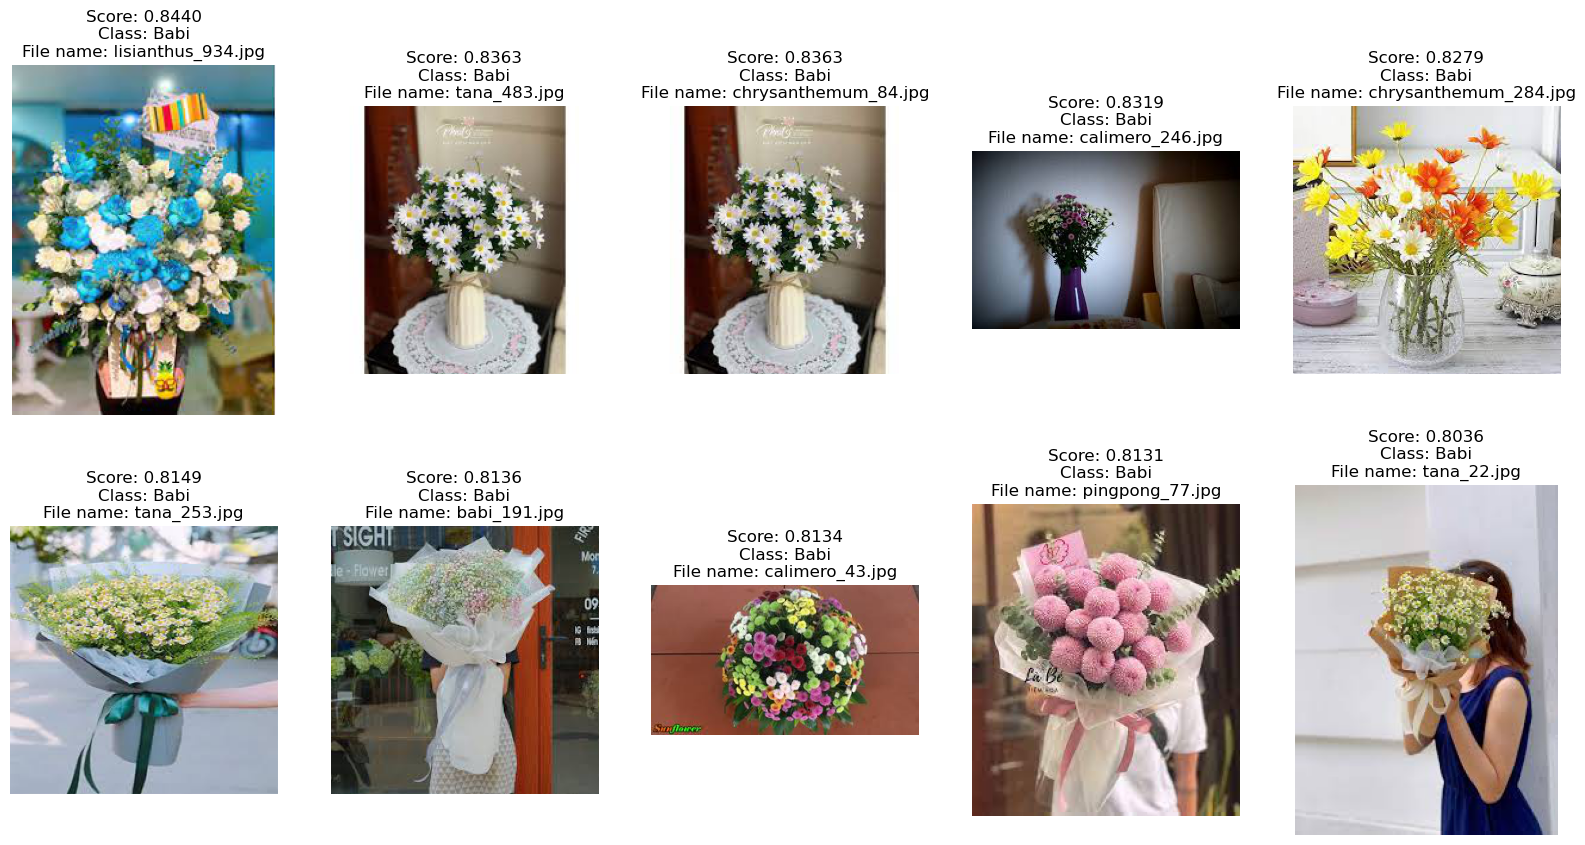

In [72]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils import data

# define function to compute similarity scores
def compute_similarity_scores(test_image, train_dir):
    # define transformations to apply to all images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # create datasets and data loaders for training images
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    train_loader = data.DataLoader(train_dataset, batch_size=16, shuffle=True)

    # compute feature vectors for all training images
    features_list = []
    labels_list = []
    for images, labels in train_loader:
        with torch.no_grad():
            features = model(images)
            features_list.append(features)
            labels_list.append(labels)
    train_features = torch.cat(features_list, dim=0)
    train_labels = torch.cat(labels_list, dim=0)

    # compute feature vector for test image
    test_image = transform(test_image).unsqueeze(0)
    with torch.no_grad():
        test_features = model(test_image)

    # compute cosine similarity scores between test image and all training images
    similarity_scores = torch.nn.functional.cosine_similarity(train_features, test_features)

    # get top 10 most similar images and their labels
    top_k_scores, top_k_indices = torch.topk(similarity_scores, k=10, dim=0)
    top_k_images = [train_dataset.imgs[i][0] for i in top_k_indices]
    top_k_labels = [train_dataset.classes[train_labels[i]] for i in top_k_indices]

    return top_k_images, top_k_labels, top_k_scores

# define paths to test image and training images
test_image_path = 'Test/Babi/babi_40.jpg'
train_dir_path = 'Train'

# load the test image
test_image = Image.open(test_image_path)

# compute similarity scores between test image and all training images
top_k_images, top_k_labels, top_k_scores = compute_similarity_scores(test_image, train_dir_path)

# plot the top 10 most similar images and their labels
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten()
for i in range(len(top_k_images)):
    image_path = top_k_images[i]
    similar_image = Image.open(image_path)
    axs[i].imshow(similar_image)
    axs[i].set_title(f"Score: {top_k_scores[i]:.4f}\nClass: {top_k_labels[i]}\nFile name: {os.path.basename(image_path)}")
    axs[i].axis('off')
plt.show()


In [69]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils import data

# define custom model
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(32 * 56 * 56, 128)
        self.fc2 = torch.nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        return x

# define function to compute similarity scores
def compute_similarity_scores(test_image, train_dir, val_dir):

    # define the model to use
    model = MyModel()

    # define transformations to apply to all images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # create datasets and data loaders for training images
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    train_loader = data.DataLoader(train_dataset, batch_size=16, shuffle=True)

    # create datasets and data loaders for validation images
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
    val_loader = data.DataLoader(val_dataset, batch_size=16, shuffle=True)

    # train the model
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    num_epochs = 5

    for epoch in range(num_epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # compute feature vectors for all training images
    features_list = []
    labels_list = []
    for images, labels in train_loader:
        with torch.no_grad():
            features = model(images)
            features_list.append(features)
            labels_list.append(labels)
    train_features = torch.cat(features_list, dim=0)
    train_labels = torch.cat(labels_list, dim=0)

    # compute feature vectors for all validation images
    features_list = []
    labels_list = []
    for images, labels in val_loader:
        with torch.no_grad():
            features = model(images)
            features_list.append(features)
            labels_list.append(labels)
    val_features = torch.cat
    (features_list, dim=0)
    val_labels = torch.cat(labels_list, dim=0)

    # compute feature vector for test image
    test_image = transform(test_image)
    test_image = test_image.unsqueeze(0)
    with torch.no_grad():
        test_feature = model(test_image)

    # compute similarity scores
    similarity_scores = torch.nn.functional.cosine_similarity(test_feature, train_features)
    similarity_scores = similarity_scores.squeeze()
    top_scores, top_indices = similarity_scores.topk(k=5, dim=0)

    # print top matching images and their similarity scores
    print("Top 5 matching images:")
    for score, idx in zip(top_scores, top_indices):
        img_path = train_dataset.imgs[idx][0]
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"Similarity score: {score.item():.2f}")
        plt.show()


Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to C:\Users\ga020/.cache\torch\hub\v0.9.0.zip
C:\Users\ga020\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ga020\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FileNotFoundError: [Errno 2] No such file or directory: 'test_image.jpg'